In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Input
from tensorflow.io import FixedLenFeature
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import numpy as np

import os
import time
import random

## Functions

In [2]:
# SHOW TRAINING INSTANCES

def show_instance_xy(X, y, index=None):
    if index == None:
        index = random.randrange(len(X))
    plt.imshow(X[index])
    plt.title(f"Instance {index}")
    plt.axis("off")
    plt.show()
    print(y[index].numpy())


def show_instance_ds(data, index=None):
    if index == None:
        index = random.randrange(len(data))
    plt.imshow(data[index][0], cmap="gray")
    plt.title(f"Instance {index}")
    plt.axis("off")
    plt.show()
    print(data[index][1])

#-----#-----#-----#-----#-----#-----#-----#-----#
    
# HIGH-LEVEL READ AND PROCESS DATA

def _parse_function(example_proto):
    feature_description = {
        "image_raw": FixedLenFeature([], tf.string),
        "label" : FixedLenFeature([], tf.string),
        }
    return tf.io.parse_single_example(example_proto, feature_description)

def decode_tfrecord(inst):
    inst["image_raw"] = tf.io.parse_tensor(inst["image_raw"], out_type=tf.uint8)
    inst["label"] = tf.io.parse_tensor(inst["label"], out_type=tf.float32)
    return inst

def tfrecord_to_dataset(filepaths):
    dataset = tf.data.TFRecordDataset(filepaths).prefetch(1)
    dataset = dataset.map(_parse_function, num_parallel_calls=-1)
    dataset = dataset.map(decode_tfrecord, num_parallel_calls=-1)
    return dataset

def dataset_to_xy(ds):
    X, y = [], []
    for instance in ds:
        X.append(instance["image_raw"])
        y.append(instance["label"])
    return tf.stack(X), tf.stack(y)

def blur_keys_for_xy(y, blur=list(range(6, 0, -1))):
    y = blur_lists_of_list(y_full, blur)
    y = tf.stack(y)
    return y

def resize_instance(inst, end_size=(112, 224), cropped_size=(224, 448)):
    
    crop1_offset_h = 120
    crop1_offset_w = 71
    crop1_h = cropped_size[0] + 50
    crop1_w = cropped_size[1] + 50
    
    # Image pixel positioning
    # crop1
    inst["image_raw"] = tf.image.crop_to_bounding_box(inst["image_raw"], crop1_offset_h, crop1_offset_w, crop1_h, crop1_w)
    # crop2
    inst["image_raw"] = tf.image.random_crop(inst["image_raw"], (cropped_size[0], cropped_size[1], 3))
    # resize
    inst["image_raw"] = tf.image.resize(inst["image_raw"], end_size)
    
    return inst


#-----#-----#-----#-----#-----#-----#-----#-----#

# LOW-LEVEL PROCESSING AND AUGMENTATION

def blur_list(inp_list, blur_weights):
    blured_list = []
    div_factor = blur_weights[0] + sum(blur_weights[1:]) * 2
    for index in range(len(inp_list)):
        for offset, blur_weight in enumerate(blur_weights):
            if offset == 0:
                blured_val = blur_weight * inp_list[index]
            else:
                if index + offset < len(inp_list):
                    blured_val += blur_weight * inp_list[index+offset]
                else:
                    blured_val += blur_weight * inp_list[index]

                if index - offset >= 0:
                    blured_val += blur_weight * inp_list[index-offset]
                else:
                    blured_val += blur_weight * inp_list[index]
            #print(blured_val)

        blured_val /= div_factor
        blured_list.append(blured_val)
    
    return blured_list
    

def blur_lists_of_list(list2d, blur_weights):
    blured_list = []
    for key_index in range(len(list2d[0])):
        key_list = [instance[key_index] for instance in list2d]
        key_list_blured = blur_list(key_list, blur_weights)
            
        if key_index == 0:
            blured_list = [[val] for val in key_list_blured]
        else:
            for i in range(len(blured_list)):
                blured_list[i].append(key_list_blured[i])
                    
    return blured_list

# Some blures for using
blur_321 = list(range(3, 0, -1))
blur_6to1 =list(range(6, 0, -1))
blur_12to1 =list(range(12, 0, -1))
blur_24to1 =list(range(24, 0, -1))

#-----#-----#-----#-----#-----#-----#-----#-----#

def data_fetcher(file_paths, img_gen, batch_size=32):
    dataset = tfrecord_to_dataset(file_paths)
    dataset = dataset.map(resize_instance, num_parallel_calls=-1)
    X_full, y_full = dataset_to_xy(dataset)
    y_full = blur_keys_for_xy(y_full, blur_12to1)
    dataset = img_gen.flow(X_full, y_full)
    return dataset.prefetch(1)

In [3]:
# Import data

dataset_dir = "training_data"
file_paths = tf.data.Dataset.list_files("training_data/big_record_2_235k_3th-P__rev-high99/2020_12_19-21_04_57.tfrecord")

dataset = tfrecord_to_dataset(file_paths)
dataset = dataset.map(resize_instance, num_parallel_calls=-1)
X_full, y_full = dataset_to_xy(dataset)
y_full = blur_keys_for_xy(y_full, blur_24to1)

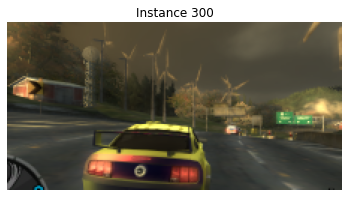

[1.       0.       0.       0.265625]


In [4]:
show_instance_xy(X_full/255, y_full, index=300)

In [5]:
print(X_full.shape)

(5000, 112, 224, 3)


In [6]:
img_gen = ImageDataGenerator(#samplewise_center=True,
                             #samplewise_std_normalization=True,
                             rotation_range=5,
                             width_shift_range=0.05,
                             height_shift_range=0.05,
                             brightness_range=(0.9, 1.1),
                             shear_range=0.1,
                             zoom_range=0.1,
                             channel_shift_range=10.,
                             horizontal_flip=False,
                             vertical_flip=False,
                             rescale=1./255,
                            )

In [7]:
aug_dataset = img_gen.flow(X_full, y_full)

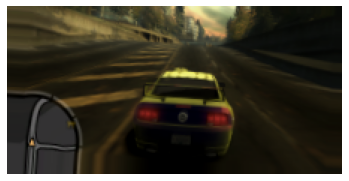

[1.         0.         0.         0.03298611]


In [8]:
plt.imshow(aug_dataset[1][0][13])
plt.axis("off")
plt.show()
print(aug_dataset[1][1][13])

## Create Model

In [9]:
# Create the model

base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False,
                                                  input_tensor=Input(shape=(112, 224, 3)),
                                                 )

In [13]:
avg_layer = keras.layers.GlobalAveragePooling2D()(base_model.output)
output_layer = keras.layers.Dense(4, activation="sigmoid")(avg_layer)
model = keras.Model(inputs=base_model.input, outputs=output_layer)

In [14]:
# freeze pretrained layers
for layer in base_model.layers:
    layer.trainable = False

In [15]:
model.compile(
    loss="mse",
    optimizer="adam",
    metrics=["accuracy"],
    )

In [18]:
t = time.strftime('%d-%m-%Y %H-%M-%S')
model_name = "Fist_test"
exp_model_path = os.path.join("models 2", f"{model_name}__{t}")

max_epochs = 20
my_batch_size = 32
my_patience = 5
root_logdir = "logs"
log_name = time.strftime("run_%Y_%m_%d-%H_%M_%S")
log_path = os.path.join(root_logdir, log_name)
my_callbacks = [keras.callbacks.EarlyStopping(patience=my_patience),
                keras.callbacks.TensorBoard(log_dir=log_path),
]

model.fit_generator(
    aug_dataset,
    epochs=max_epochs,
    callbacks=my_callbacks,
)

model.save(exp_model_path)

Epoch 1/20
  1/157 [..............................] - ETA: 0s - loss: 0.2326 - accuracy: 0.1562WARNING:tensorflow:From d:\anaconda\envs\env37\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
157/157 [==============================] - 27s 174ms/step - loss: 0.0139 - accuracy: 0.9940
Epoch 2/20
157/157 [==============================] - 27s 173ms/step - loss: 0.0082 - accuracy: 1.0000
Epoch 3/20
157/157 [==============================] - 27s 175ms/step - loss: 0.0071 - accuracy: 1.0000
Epoch 4/20
157/157 [==============================] - 27s 172ms/step - loss: 0.0065 - accuracy: 1.0000
Epoch 5/20
157/157 [==============================] - 28s 178ms/step - loss: 0.0060 - accuracy: 1.0000
Epoch 6/20
157/157 [==============================] - 27s 174ms/step - loss: 0.0058 - accuracy: 1.0000
Epoch 7/20
157/157